In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.fft import fft
from google.colab import drive
import os
import librosa
import soundfile as sf
from scipy.stats import wasserstein_distance

## KL Divergence

In [6]:
def compute_kl_divergence(reference_magnitudes, test_magnitudes, eps=1e-10):
    # Normalize to create probability distributions
    p = reference_magnitudes / (np.sum(reference_magnitudes) + eps)
    q = test_magnitudes / (np.sum(test_magnitudes) + eps)

    # Add small constant to avoid log(0)
    p = p + eps
    q = q + eps

    # Compute KL divergence
    kl_div = np.sum(p * np.log(p / q))

    return kl_div

## Wasserstein Distance

In [5]:
def compute_wasserstein(reference_magnitudes, test_magnitudes, freqs):
    # Normalize to create probability distributions
    p = reference_magnitudes / np.sum(reference_magnitudes)
    q = test_magnitudes / np.sum(test_magnitudes)

    # Compute Wasserstein distance
    distance = wasserstein_distance(freqs, freqs, p, q)

    return distance

## Audio Utility Functions

In [4]:
def load_audio_file(file_path, target_sr=44100):
    audio, sr = librosa.load(file_path, sr=target_sr)
    return audio, sr

def load_samples_from_drive(folder_path):
    audio_files = []
    valid_extensions = {'.wav'}

    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(ext) for ext in valid_extensions):
            file_path = os.path.join(folder_path, filename)
            try:
                audio, sr = load_audio_file(file_path)
                audio_files.append((audio, sr))
            except Exception as e:
                print(f"Error loading {filename}: {e}")

    return audio_files

##FFT

In [ ]:
def compute_fft(audio_samples, sample_rate, fft_size=4096):
    # Apply a Hann window to the audio samples
    window = signal.windows.hann(len(audio_samples))
    windowed_samples = audio_samples * window

    # Perform FFT and compute magnitudes
    fft_result = fft(windowed_samples, n=fft_size)
    magnitudes = np.abs(fft_result[:fft_size // 2])
    freqs = np.fft.fftfreq(fft_size, d=1/sample_rate)[:fft_size // 2]

    return freqs, magnitudes

## Aggregate Frequency Distribution

In [ ]:
def aggregate_frequency_distribution(audio_files, fft_size=4096):
    all_magnitudes = []

    for audio, sr in audio_files:
        freqs, magnitudes = compute_fft(audio, sr, fft_size)
        # Normalize magnitudes
        magnitudes = magnitudes / np.max(magnitudes)
        all_magnitudes.append(magnitudes)

    all_magnitudes = np.array(all_magnitudes)
    avg_magnitudes = np.mean(all_magnitudes, axis=0)
    std_magnitudes = np.std(all_magnitudes, axis=0)

    return freqs, avg_magnitudes, std_magnitudes

## Distribution Comparison Plotting

In [ ]:
# For comparing an individual sample w/ distribution
def compare_with_distribution(test_audio, sr, reference_freqs, reference_avg, reference_std):
    # Compute FFT for test audio
    _, test_magnitudes = compute_fft(test_audio, sr)
    test_magnitudes = test_magnitudes / np.max(test_magnitudes)

    plt.figure(figsize=(12, 6))

    plt.fill_between(reference_freqs,
                    reference_avg - reference_std,
                    reference_avg + reference_std,
                    alpha=0.3, label='Reference ±1σ')

    plt.plot(reference_freqs, reference_avg, 'b-', label='Reference Mean')
    plt.plot(reference_freqs, test_magnitudes, 'r-', label='Test Sample')

    plt.title("Frequency Distribution Comparison")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Magnitude")
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.xlim(20, 20000)  # Standard audio frequency range
    plt.show()

In [3]:
# For comparing two distributions
def compare_dist_to_dist(test_freqs, test_avg, test_std, sr, reference_freqs, reference_avg, reference_std):
    plt.figure(figsize=(12, 6))
    # Plot reference distribution with standard deviation
    plt.fill_between(reference_freqs,
                    reference_avg - reference_std,
                    reference_avg + reference_std,
                    alpha=0.3, color='blue', label='Reference ±1σ')
    # Plot test distribution with standard deviation
    plt.fill_between(test_freqs,
                    test_avg - test_std,
                    test_avg + test_std,
                    alpha=0.3, color='red', label='Test ±1σ')
    # Plot mean lines
    plt.plot(reference_freqs, reference_avg, 'b-', label='Reference Mean')
    plt.plot(test_freqs, test_avg, 'r-', label='Test Mean')

    plt.title("Frequency Distribution Comparison")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Magnitude")
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.xlim(20, 20000)  # Standard audio frequency range
    plt.show()

## Diffwave Output Upsampled vs. High Quality Samples

Loading reference samples...
Loading test samples...
Computing reference distribution...
Comparing distributions...


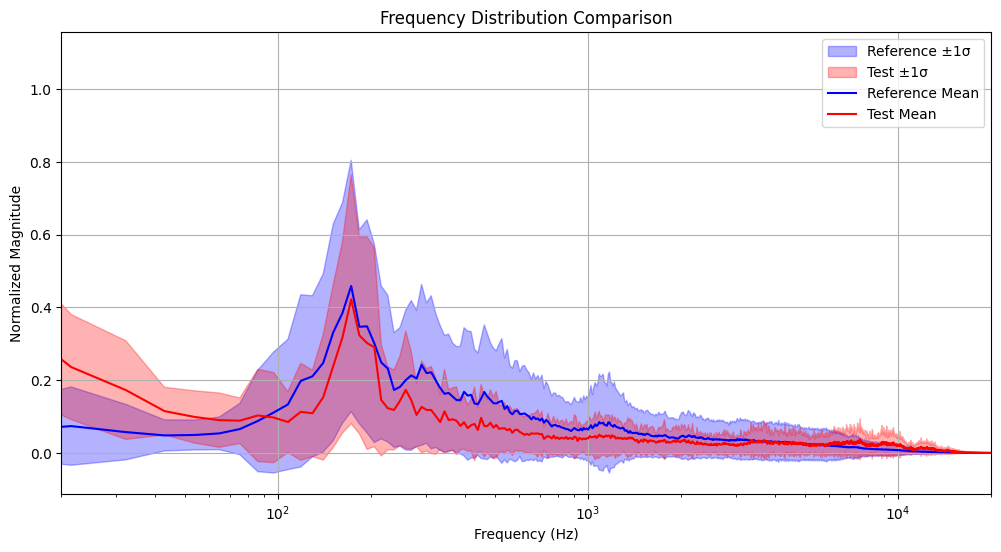

In [8]:
reference_folder = '/content/drive/MyDrive/snare_samples/16bit_mono_wavs_clipped_44100/training'
test_sample_path = '/content/drive/MyDrive/271_proj/diffwaveOUTPUT_upsampled'

# Load reference samples
print("Loading reference samples...")
reference_samples = load_samples_from_drive(reference_folder)
print("Loading test samples...")
test_samples = load_samples_from_drive(test_sample_path)

if not reference_samples:
    print("No audio files found in the reference folder!")
    exit()

if not test_samples:
    print("No audio files found in the test folder!")
    exit()

print("Computing reference distribution...")
freqs, avg_magnitudes, std_magnitudes = aggregate_frequency_distribution(reference_samples)
print("Computing test distribution...")
test_freqs, test_avg_magnitudes, test_std_magnitudes = aggregate_frequency_distribution(test_samples)

# Compare distributions
print("Comparing distributions...")
compare_dist_to_dist(test_freqs, test_avg_magnitudes, test_std_magnitudes, 44100, freqs, avg_magnitudes, std_magnitudes)

In [12]:
kl_div = compute_kl_divergence(avg_magnitudes, test_avg_magnitudes)
print(f"KL Divergence: {kl_div:.4f}")
wass_dist = compute_wasserstein(avg_magnitudes, test_avg_magnitudes, freqs)
print(f"Wasserstein Distance: {wass_dist:.4f}")

KL Divergence: 0.1766
Wasserstein Distance: 1785.0184


## WaveGAN Output Upsampled vs. High Quality Samples

Loading reference samples...
Loading test samples...
Computing reference distribution...
Comparing distributions...


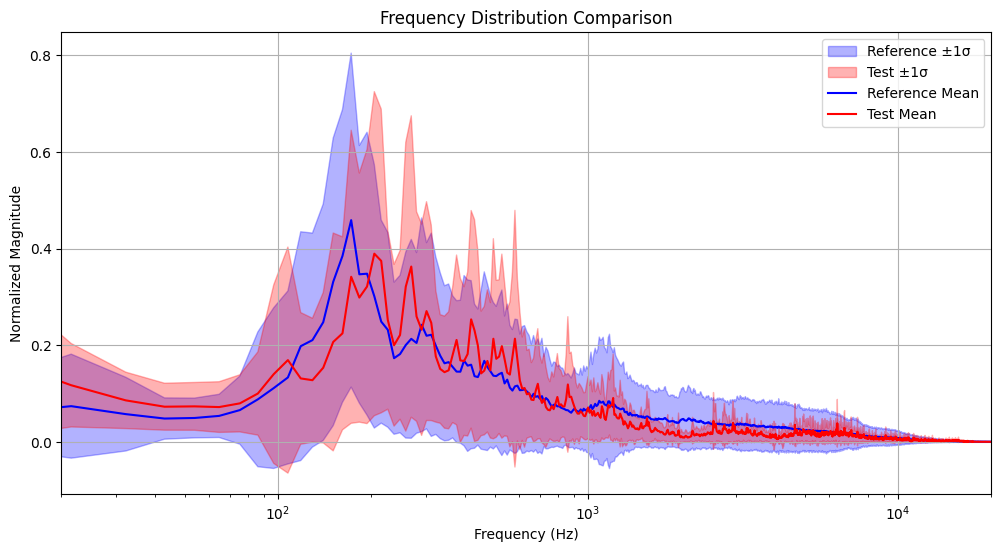

KL Divergence: 0.1062
Wasserstein Distance: 405.9322


In [11]:
reference_folder = '/content/drive/MyDrive/snare_samples/16bit_mono_wavs_clipped_44100/training'
test_sample_path = '/content/drive/MyDrive/271_proj/waveGAN_outputs_upsampled'

# Load reference samples
print("Loading reference samples...")
reference_samples = load_samples_from_drive(reference_folder)
print("Loading test samples...")
test_samples = load_samples_from_drive(test_sample_path)

if not reference_samples:
    print("No audio files found in the reference folder!")
    exit()

if not test_samples:
    print("No audio files found in the test folder!")
    exit()

# Compute reference distribution
print("Computing reference distribution...")
freqs, avg_magnitudes, std_magnitudes = aggregate_frequency_distribution(reference_samples)
print("Computing test distribution...")
test_freqs, test_avg_magnitudes, test_std_magnitudes = aggregate_frequency_distribution(test_samples)

# Compare distributions
print("Comparing distributions...")
compare_dist_to_dist(test_freqs, test_avg_magnitudes, test_std_magnitudes, 44100, freqs, avg_magnitudes, std_magnitudes)

kl_div = compute_kl_divergence(avg_magnitudes, test_avg_magnitudes)
print(f"KL Divergence: {kl_div:.4f}")
wass_dist = compute_wasserstein(avg_magnitudes, test_avg_magnitudes, freqs)
print(f"Wasserstein Distance: {wass_dist:.4f}")

## Diffwave Output vs. High Quality Samples

Loading reference samples...
Loading test samples...
Computing reference distribution...
Comparing distributions...


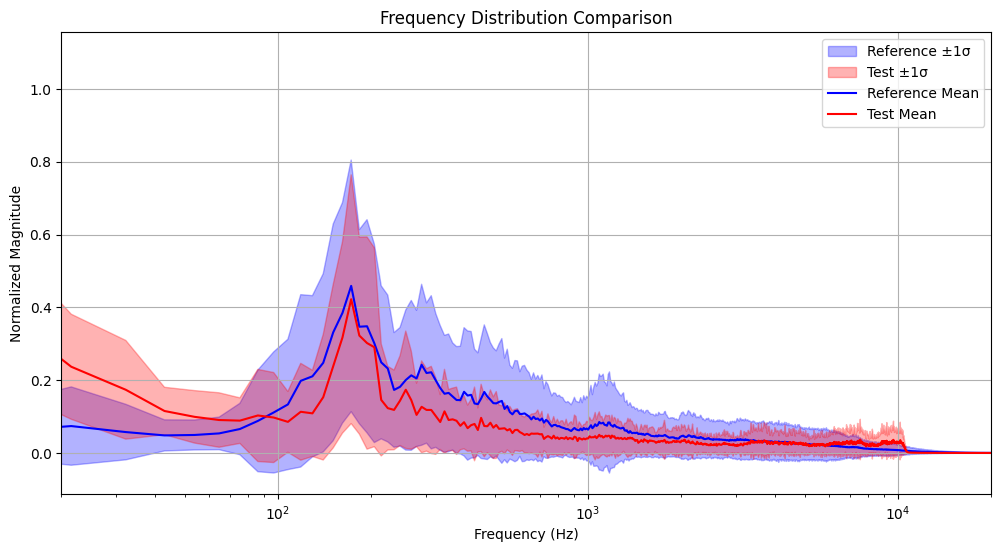

KL Divergence: 0.1835
Wasserstein Distance: 1164.6888


In [12]:
reference_folder = '/content/drive/MyDrive/snare_samples/16bit_mono_wavs_clipped_44100/training'
test_sample_path = '/content/drive/MyDrive/271_proj/diffwaveOUTPUT'

# Load reference samples
print("Loading reference samples...")
reference_samples = load_samples_from_drive(reference_folder)
print("Loading test samples...")
test_samples = load_samples_from_drive(test_sample_path)

if not reference_samples:
    print("No audio files found in the reference folder!")
    exit()

if not test_samples:
    print("No audio files found in the test folder!")
    exit()

# Compute reference distribution
print("Computing reference distribution...")
freqs, avg_magnitudes, std_magnitudes = aggregate_frequency_distribution(reference_samples)
print("Computing test distribution...")
test_freqs, test_avg_magnitudes, test_std_magnitudes = aggregate_frequency_distribution(test_samples)

# Compare distributions
print("Comparing distributions...")
compare_dist_to_dist(test_freqs, test_avg_magnitudes, test_std_magnitudes, 44100, freqs, avg_magnitudes, std_magnitudes)
kl_div = compute_kl_divergence(avg_magnitudes, test_avg_magnitudes)
print(f"KL Divergence: {kl_div:.4f}")
wass_dist = compute_wasserstein(avg_magnitudes, test_avg_magnitudes, freqs)
print(f"Wasserstein Distance: {wass_dist:.4f}")

## WaveGAN Output vs. High Quality Samples

Loading reference samples...
Loading test samples...
Computing reference distribution...
Comparing distributions...


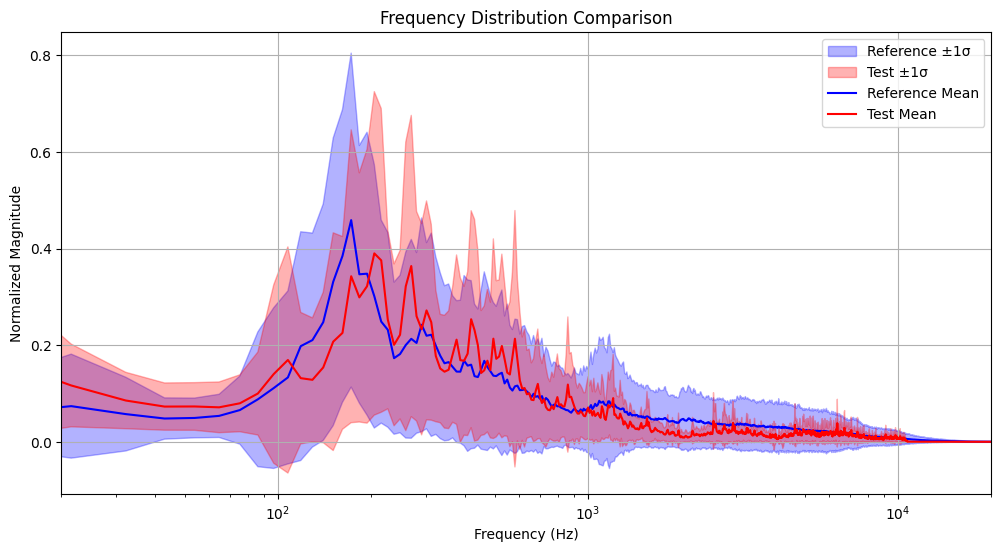

KL Divergence: 0.1296
Wasserstein Distance: 600.6578


In [13]:
reference_folder = '/content/drive/MyDrive/snare_samples/16bit_mono_wavs_clipped_44100/training'
test_sample_path = '/content/drive/MyDrive/271_proj/waveGAN_results/generated_samples'

# Load reference samples
print("Loading reference samples...")
reference_samples = load_samples_from_drive(reference_folder)
print("Loading test samples...")
test_samples = load_samples_from_drive(test_sample_path)

if not reference_samples:
    print("No audio files found in the reference folder!")
    exit()

if not test_samples:
    print("No audio files found in the test folder!")
    exit()

# Compute reference distribution
print("Computing reference distribution...")
freqs, avg_magnitudes, std_magnitudes = aggregate_frequency_distribution(reference_samples)
print("Computing test distribution...")
test_freqs, test_avg_magnitudes, test_std_magnitudes = aggregate_frequency_distribution(test_samples)

# Compare distributions
print("Comparing distributions...")
compare_dist_to_dist(test_freqs, test_avg_magnitudes, test_std_magnitudes, 44100, freqs, avg_magnitudes, std_magnitudes)

kl_div = compute_kl_divergence(avg_magnitudes, test_avg_magnitudes)
print(f"KL Divergence: {kl_div:.4f}")
wass_dist = compute_wasserstein(avg_magnitudes, test_avg_magnitudes, freqs)
print(f"Wasserstein Distance: {wass_dist:.4f}")